In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from ucimlrepo import fetch_ucirepo 

import gudhi

from TopoMapCut import TopoMapCut
from TopoMap import TopoMap

In [2]:
def plot_persistance_diagram(X):
    rips_original = gudhi.RipsComplex(points=X.to_numpy())
    st_original = rips_original.create_simplex_tree(max_dimension=1)

    diag_original = st_original.persistence(min_persistence=0)

    # Create image
    fig, axs = plt.subplots(1, 1, figsize=(4, 4))

    gudhi.plot_persistence_diagram(diag_original, axes=axs)
    axs.set_title('Persistance Diagram')

    return fig

def plot_persistance_diagrams_projection(X, proj, y, y_column='class'):
    rips_original = gudhi.RipsComplex(points=X.to_numpy())
    st_original = rips_original.create_simplex_tree(max_dimension=1)

    rips_proj = gudhi.RipsComplex(points=proj)
    st_projection = rips_proj.create_simplex_tree(max_dimension=1)

    diag_original = st_original.persistence(min_persistence=0)
    diag_proj = st_projection.persistence(min_persistence=0)

    I_original = st_original.persistence_intervals_in_dimension(1)
    I_proj = st_projection.persistence_intervals_in_dimension(1)

    bt_blobs = gudhi.bottleneck_distance(I_original, I_proj)
    print(f"Bottleneck distance: {bt_blobs:.10f}")    

    # Create image
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    gudhi.plot_persistence_diagram(diag_original, axes=axs[0])
    axs[0].set_title('Persistance - Original Points')

    gudhi.plot_persistence_diagram(diag_proj, axes=axs[1])
    axs[1].set_title('Persistance - Projections')

    colors = [px.colors.qualitative.D3[i] for i in range(10)]

    i = 0
    for cluster in y[y_column].unique():
        i_cluster = list(y[y[y_column]==cluster].index)
        axs[2].scatter(proj[i_cluster,0], proj[i_cluster,1],
                c=colors[i], s=5)
        i += 1
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title('Projection')
    
    fig.suptitle('Persistence diagrams and Projection')
    fig.tight_layout()
    
    return fig

def plot_proj_min_dists(X, y, y_column, min_dists,
                        proj_method='tsne', rescale=True):
    
    colors = [px.colors.qualitative.D3[i] for i in range(10)]
    
    projs = []

    for d in min_dists:
        topocut = TopoMapCut(X.to_numpy())
        components = topocut.get_components(min_dist=d)
        proj_subsets = topocut.project_components(proj_method=proj_method, rescale=rescale)
        projs.append(topocut.join_components())

    y_column = 'class'
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    for d in range(len(min_dists)):
        i = 0
        for cluster in y[y_column].unique():
            i_cluster = list(y[y[y_column]==cluster].index)
            axs[d].scatter(projs[d][i_cluster,0], projs[d][i_cluster,1],
                    c=colors[i], s=5)
            i += 1
            
        axs[d].set_xticks([])
        axs[d].set_yticks([])
        axs[d].set_title(f'Min dist = {min_dists[d]}')

    fig.suptitle('Projection with different min dist')
    plt.tight_layout()

    return fig

def plot_proj_max_comps(X, y, y_column, max_comps,
                        proj_method='tsne', rescale=True):
    
    colors = [px.colors.qualitative.D3[i] for i in range(10)]
    
    projs = []

    for d in max_comps:
        topocut = TopoMapCut(X.to_numpy())
        components = topocut.get_components(max_components=d)
        proj_subsets = topocut.project_components(proj_method=proj_method, rescale=rescale)
        projs.append(topocut.join_components())

    y_column = 'class'
    n_plots = len(max_comps)
    fig, axs = plt.subplots(1, n_plots, figsize=(n_plots*4, 4))

    for d in range(n_plots):
        i = 0
        for cluster in y[y_column].unique():
            i_cluster = list(y[y[y_column]==cluster].index)
            axs[d].scatter(projs[d][i_cluster,0], projs[d][i_cluster,1],
                    c=colors[i], s=5)
            i += 1
            
        axs[d].set_xticks([])
        axs[d].set_yticks([])
        axs[d].set_title(f'Max components = {max_comps[d]}')

    fig.suptitle('Projection with different max_components')
    plt.tight_layout()

    return fig

## Iris

In [41]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

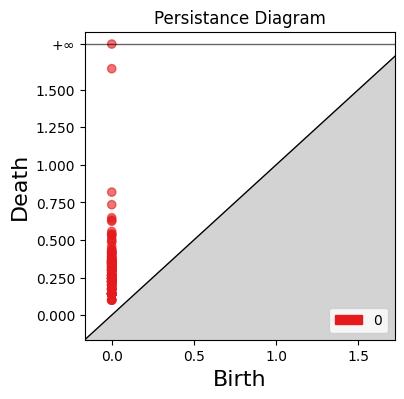

In [42]:
plot_persistance_diagram(X)
plt.show()

In [43]:
min_dist = 0.5
topocut_iris = TopoMapCut(X.to_numpy())
components = topocut_iris.get_components(min_dist=min_dist, 
                                         max_components=20)
proj_subsets = topocut_iris.project_components(proj_method='tsne', rescale=False)
proj_iris = topocut_iris.join_components()
print(f'Number of components: {len(topocut_iris.subsets)}')

[INFO] Max components hit. # components: 20 | Max_components: 20
Number of components: 20


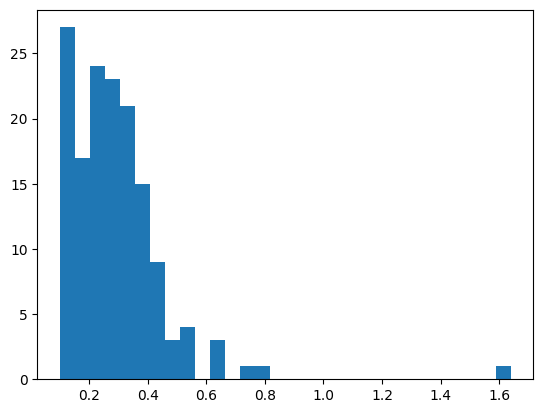

In [44]:
edges = [edge[-1]['weight'] for edge in topocut_iris.sorted_edges]
plt.hist(edges, bins=30)
plt.show()

Bottleneck distance: 0.0000000000


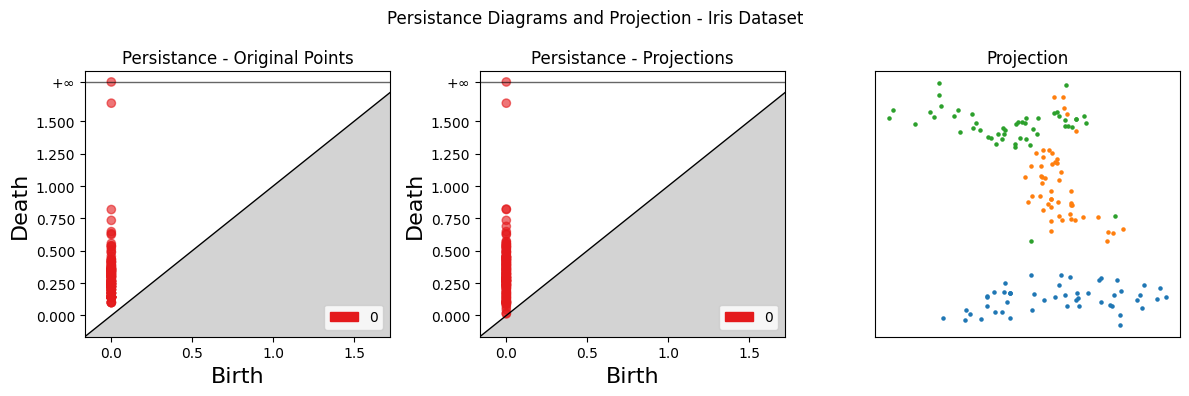

In [45]:
fig_iris = plot_persistance_diagrams_projection(X, proj_iris, y)
fig_iris.suptitle('Persistance Diagrams and Projection - Iris Dataset')
plt.show()

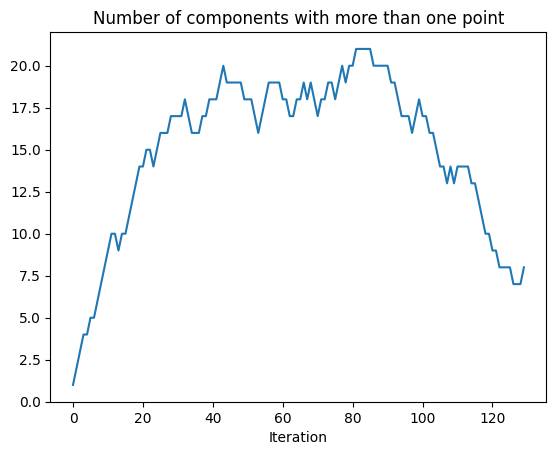

In [46]:
plt.plot(topocut_iris.n_components_non_single)
plt.title('Number of components with more than one point')
plt.xlabel('Iteration')
plt.show()

[INFO] Min distance hit. Distance: 0.26457513110645864 | Min_dist: 0.25
[INFO] Min distance hit. Distance: 0.5099019513592786 | Min_dist: 0.5
[INFO] Min distance hit. Distance: 0.818535277187245 | Min_dist: 0.75
[INFO] Min distance hit. Distance: 1.6401219466856727 | Min_dist: 1.0
[INFO] Number of edges hit. Edges processed: 148


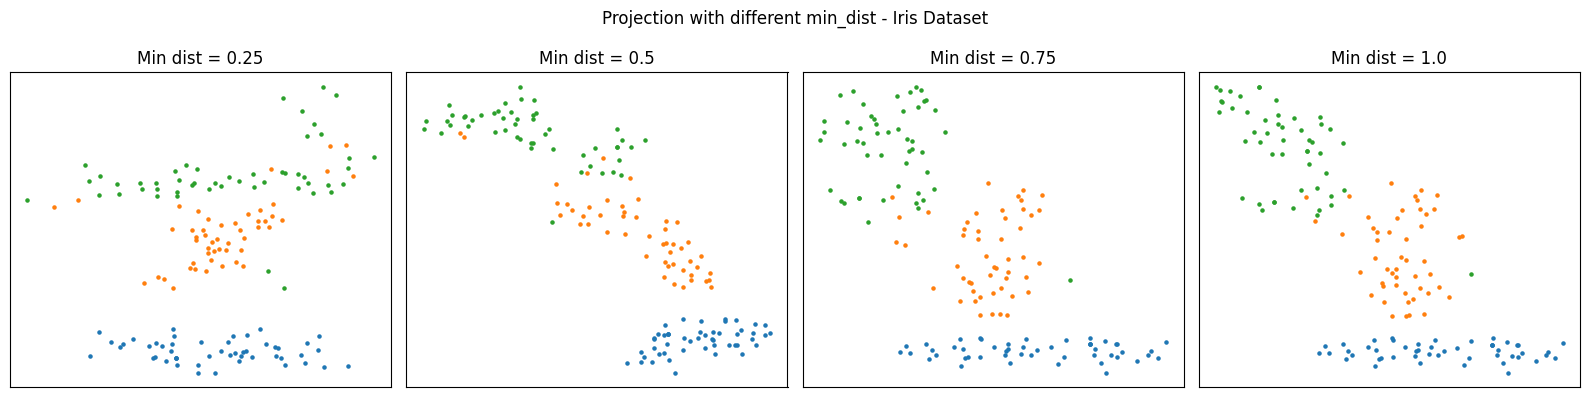

In [47]:
min_dists_iris = [0.25, 0.5, 0.75, 1.0]
fig = plot_proj_min_dists(X, y, 'class', min_dists_iris, rescale=False)
fig.suptitle('Projection with different min_dist - Iris Dataset')
plt.show()

## Seeds

In [48]:
data_seeds = pd.read_csv('data/UCI/seeds/seeds_dataset.txt', sep='\t',
                         header=None,
                         names=['x1','x2','x3','x4','x5','x6','x7','class'])

X_seeds = data_seeds.copy().drop(['class'], axis=1)
y_seeds = data_seeds[['class']]

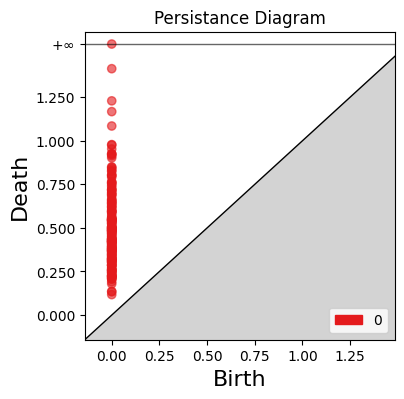

In [49]:
plot_persistance_diagram(X_seeds)
plt.show()

In [50]:
min_dist = 1.0

topocut_seeds = TopoMapCut(X_seeds.to_numpy())
components = topocut_seeds.get_components(min_dist=min_dist)
proj_seeds = topocut_seeds.project_components(proj_method='tsne', rescale=False)
proj_seeds = topocut_seeds.join_components()
print(f'Number of components: {len(topocut_seeds.subsets)}')

[INFO] Min distance hit. Distance: 1.084635127588997 | Min_dist: 1.0
Number of components: 5


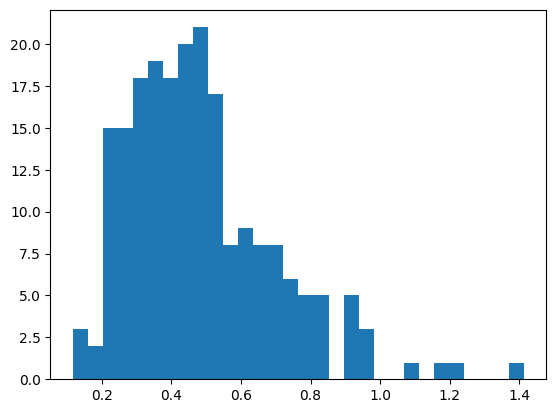

In [51]:
edges = [edge[-1]['weight'] for edge in topocut_seeds.sorted_edges]
plt.hist(edges, bins=30)
plt.show()

Bottleneck distance: 0.0000000000


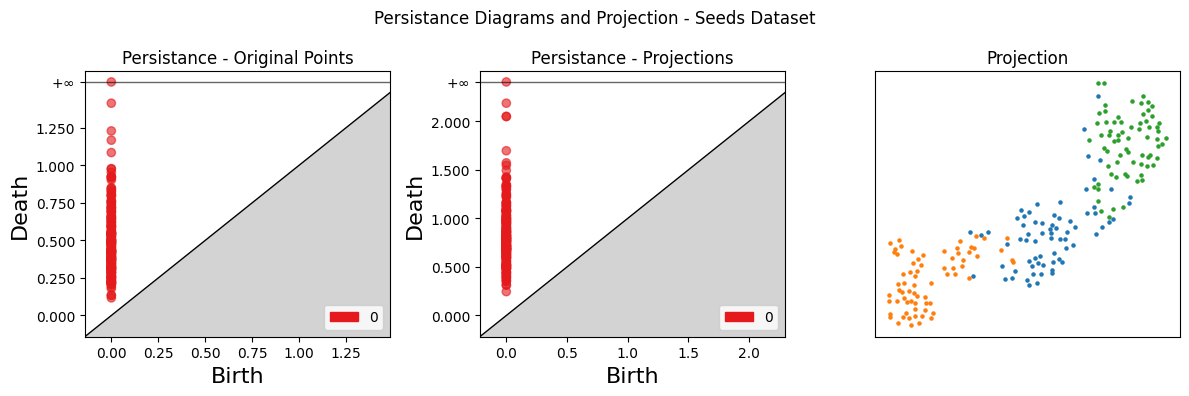

In [52]:
fig_seeds = plot_persistance_diagrams_projection(X_seeds, proj_seeds, y_seeds)
fig_seeds.suptitle('Persistance Diagrams and Projection - Seeds Dataset')
plt.show()

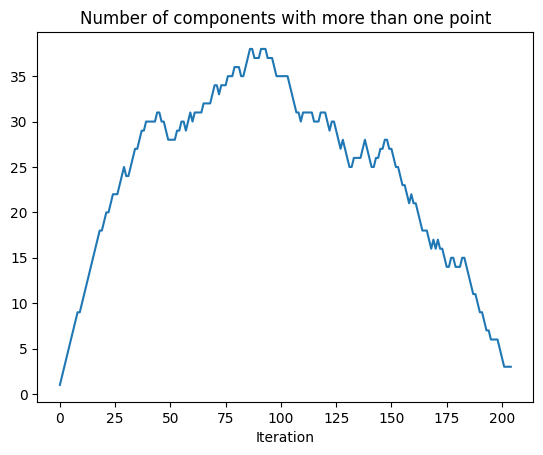

In [53]:
plt.plot(topocut_seeds.n_components_non_single)
plt.title('Number of components with more than one point')
plt.xlabel('Iteration')
plt.show()

[INFO] Min distance hit. Distance: 0.25306291707794615 | Min_dist: 0.25
[INFO] Min distance hit. Distance: 0.5009622840094853 | Min_dist: 0.5
[INFO] Min distance hit. Distance: 0.7559737098603362 | Min_dist: 0.75
[INFO] Min distance hit. Distance: 1.084635127588997 | Min_dist: 1.0


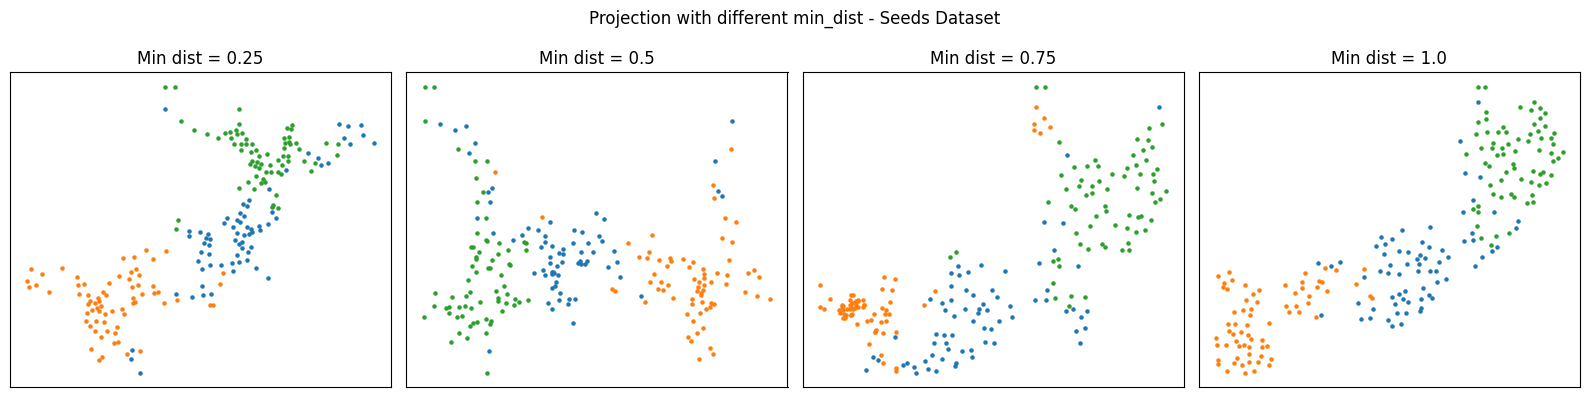

In [54]:
min_dists_seeds = [0.25, 0.5, 0.75, 1.0]
fig = plot_proj_min_dists(X_seeds, y_seeds, 'class', min_dists_seeds, rescale=False)
fig.suptitle('Projection with different min_dist - Seeds Dataset')
plt.show()

## Cancer

In [55]:
# fetch dataset 
breast_cancer_wisconsin_original = fetch_ucirepo(id=15) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_original.data.features 
y = breast_cancer_wisconsin_original.data.targets 

y_column = 'Class'

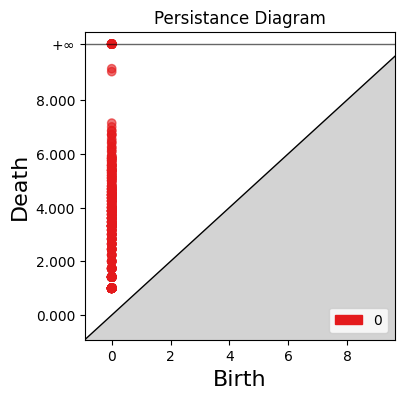

In [56]:
plot_persistance_diagram(X)
plt.show()

In [57]:
min_dist = 2.0

topocut_cancer = TopoMapCut(X.to_numpy())
components = topocut_cancer.get_components(min_dist=min_dist)
print(f'Number of components: {len(topocut_cancer.subsets)}')
proj_comp = topocut_cancer.project_components(proj_method='tsne')
proj_cancer = topocut_cancer.join_components()

[INFO] Min distance hit. Distance: 2.0 | Min_dist: 2.0
Number of components: 304


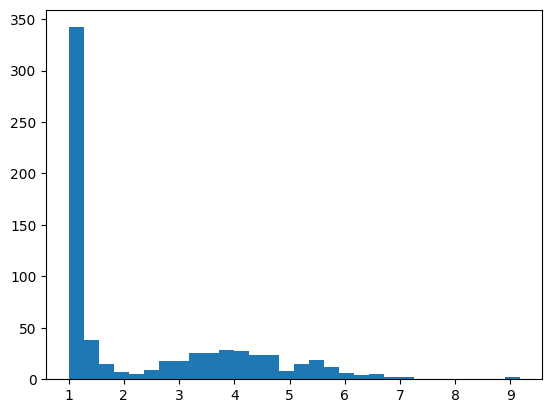

In [58]:
edges = [edge[-1]['weight'] for edge in topocut_cancer.sorted_edges]
plt.hist(edges, bins=30)
plt.show()

Bottleneck distance: 0.0000000000


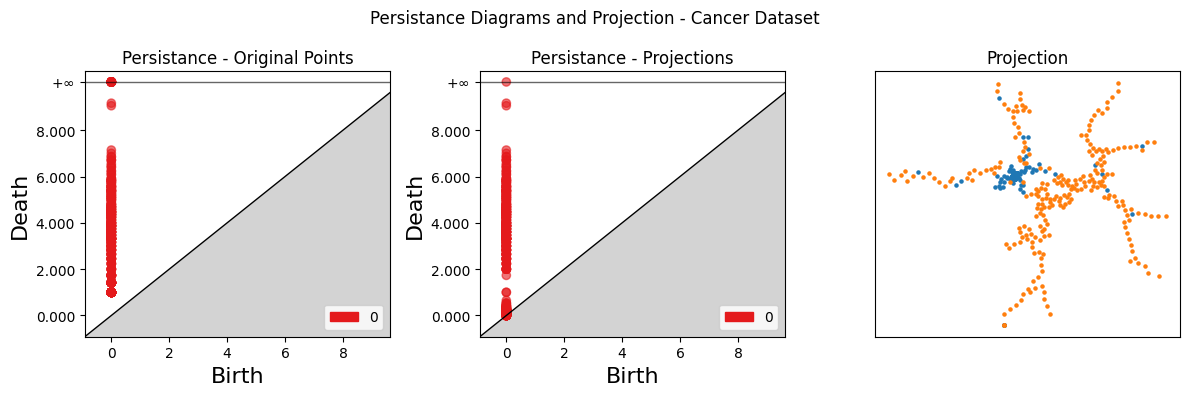

In [59]:
fig_cancer = plot_persistance_diagrams_projection(X, proj_cancer, y, y_column=y_column)
fig_cancer.suptitle('Persistance Diagrams and Projection - Cancer Dataset')
plt.show()

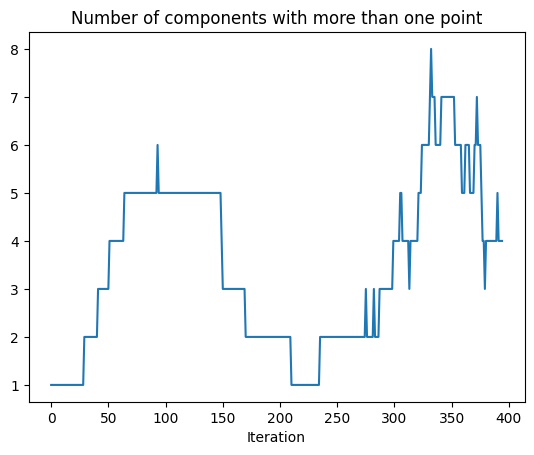

In [60]:
plt.plot(topocut_cancer.n_components_non_single)
plt.title('Number of components with more than one point')
plt.xlabel('Iteration')
plt.show()

## MFeat

In [61]:
data_mfeat = pd.read_csv('data/UCI/multiple+features/mfeat-kar', sep='\s+',
                         header=None,
                         names=['x'+str(i) for i in range(1,65)])
data_mfeat['class'] = 0
for i, row in data_mfeat.iterrows():
    data_mfeat.loc[i,'class'] = i//200

X_mfeat = data_mfeat.drop(['class'], axis=1)
y_mfeat = data_mfeat[['class']]

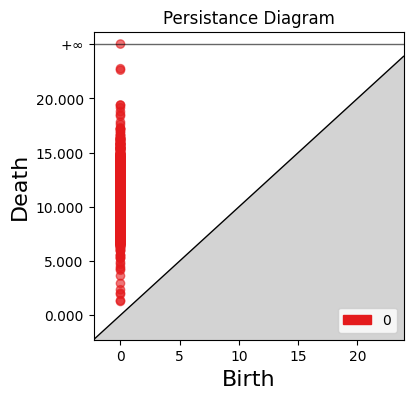

In [62]:
plot_persistance_diagram(X_mfeat)
plt.show()

In [63]:
min_dist = 20
max_components = 30

topocut_mfeat = TopoMapCut(X_mfeat.to_numpy())
components = topocut_mfeat.get_components(min_dist=min_dist, 
                                          max_components=max_components,
                                          max_comp_non_single=20)
print(f'Number of components: {len(topocut_mfeat.subsets)}')
proj_comp = topocut_mfeat.project_components(proj_method='tsne', rescale=False)
proj_mfeat = topocut_mfeat.join_components()

[INFO] Max components non single hit. # components non single: 20
Number of components: 179


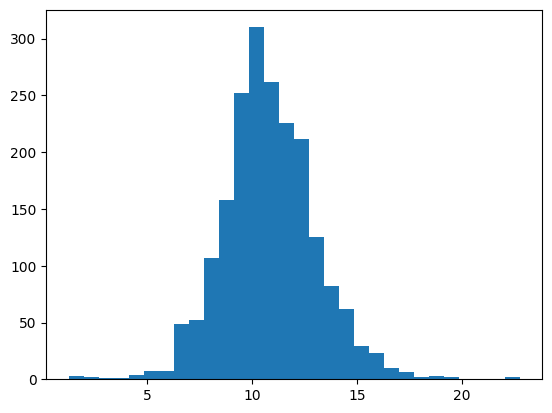

In [64]:
edges = [edge[-1]['weight'] for edge in topocut_mfeat.sorted_edges]
plt.hist(edges, bins=30)
plt.show()

Bottleneck distance: 0.0000000000


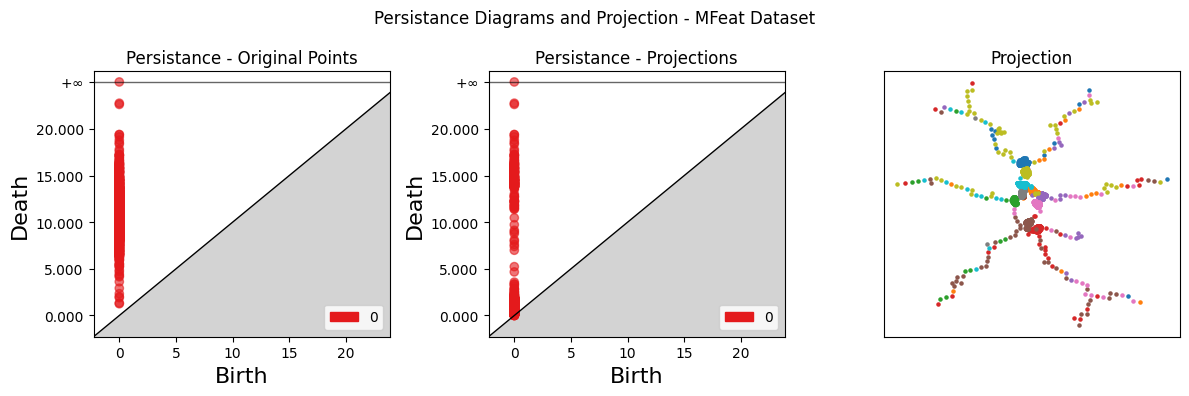

In [65]:
fig_mfeat = plot_persistance_diagrams_projection(X_mfeat, proj_mfeat, y_mfeat)
fig_mfeat.suptitle('Persistance Diagrams and Projection - MFeat Dataset')
plt.show()

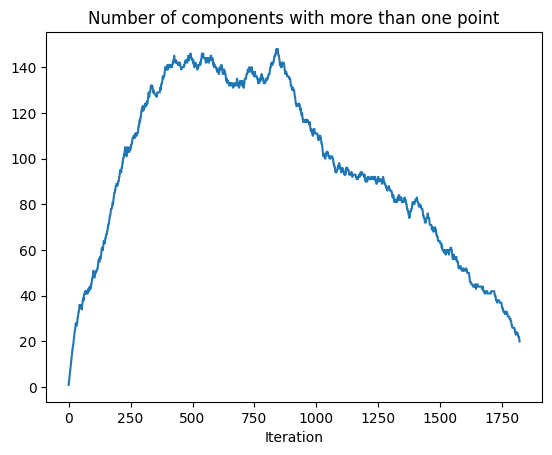

In [66]:
plt.plot(topocut_mfeat.n_components_non_single)
plt.title('Number of components with more than one point')
plt.xlabel('Iteration')
plt.show()

[INFO] Min distance hit. Distance: 5.215668904232068 | Min_dist: 5.0
[INFO] Min distance hit. Distance: 10.001378367027483 | Min_dist: 10.0
[INFO] Min distance hit. Distance: 15.018668971463637 | Min_dist: 15.0
[INFO] Min distance hit. Distance: 22.61805324307659 | Min_dist: 20.0


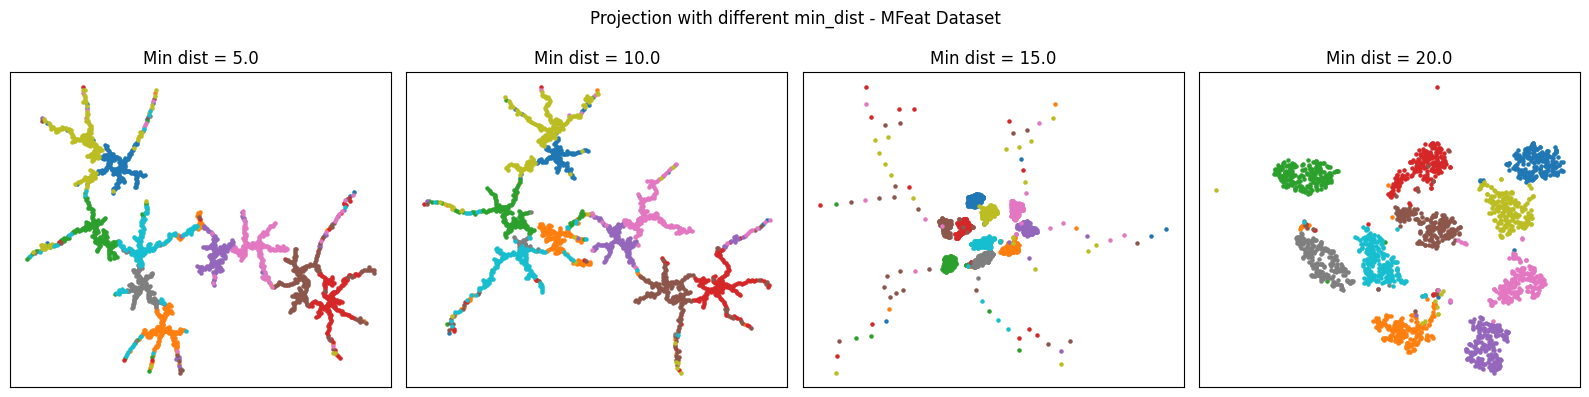

In [67]:
min_dists_mfeat = [5.0, 10.0, 15.0, 20.0]
fig = plot_proj_min_dists(X_mfeat, y_mfeat, 'class', min_dists_mfeat, rescale=False)
fig.suptitle('Projection with different min_dist - MFeat Dataset')
plt.show()

[INFO] Min distance hit. Distance: 11.003201170429453 | Min_dist: 11
[INFO] Min distance hit. Distance: 12.000167091143423 | Min_dist: 12
[INFO] Min distance hit. Distance: 13.002169555546606 | Min_dist: 13
[INFO] Min distance hit. Distance: 14.00047809007377 | Min_dist: 14


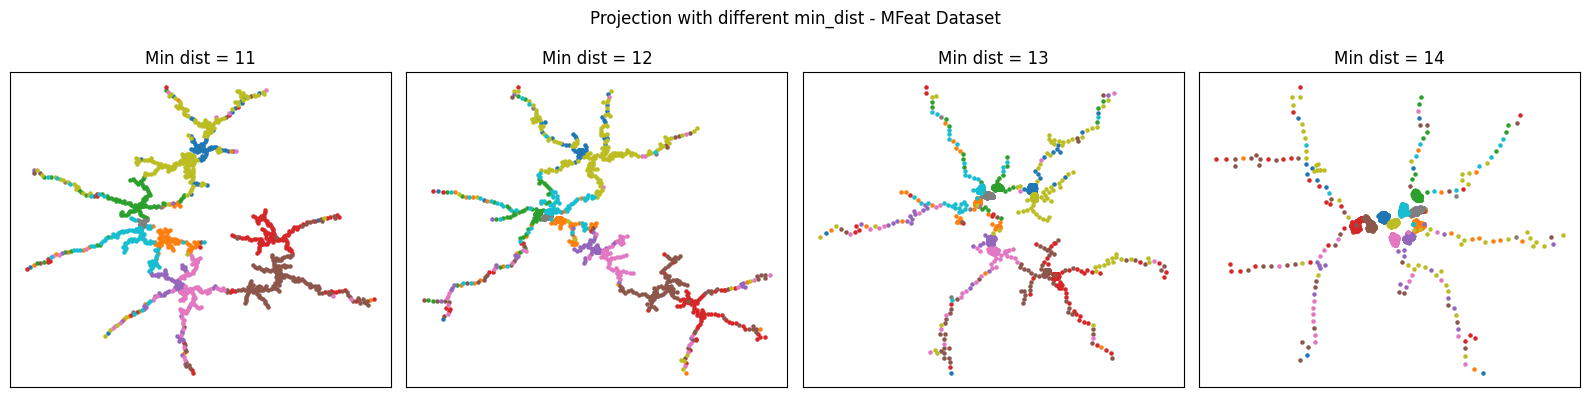

In [68]:
min_dists_mfeat = [11, 12, 13, 14]
fig = plot_proj_min_dists(X_mfeat, y_mfeat, 'class', min_dists_mfeat, rescale=False)
fig.suptitle('Projection with different min_dist - MFeat Dataset')
plt.show()

[INFO] Min distance hit. Distance: 13.002169555546606 | Min_dist: 13
[INFO] Min distance hit. Distance: 13.252421351276407 | Min_dist: 13.25
[INFO] Min distance hit. Distance: 13.504234472238249 | Min_dist: 13.5
[INFO] Min distance hit. Distance: 13.778538942134142 | Min_dist: 13.75


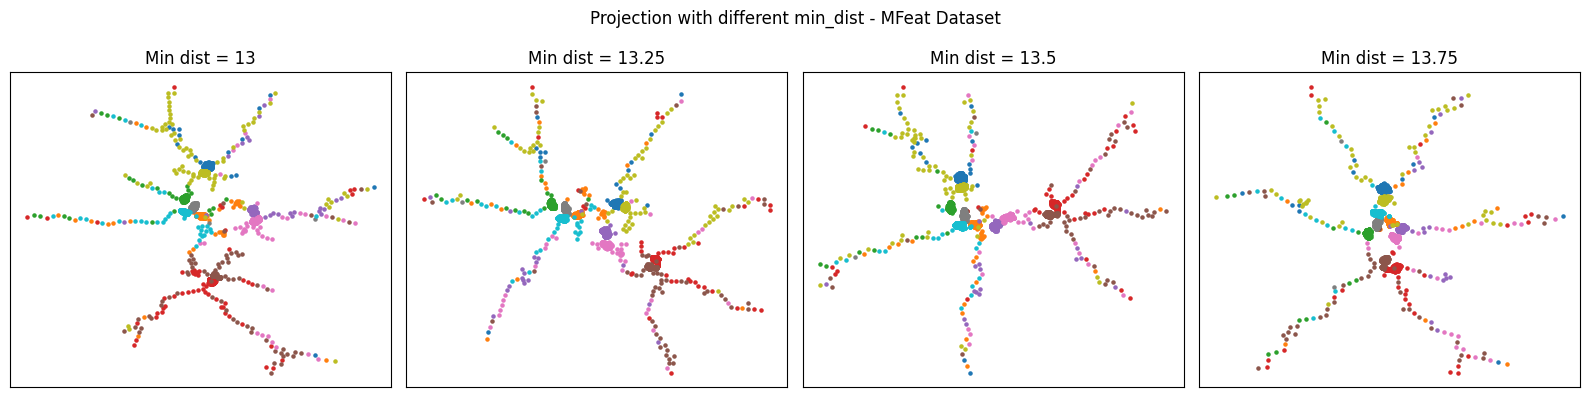

In [69]:
min_dists_mfeat = [13, 13.25, 13.50, 13.75]
fig = plot_proj_min_dists(X_mfeat, y_mfeat, 'class', min_dists_mfeat, rescale=False)
fig.suptitle('Projection with different min_dist - MFeat Dataset')
plt.show()

[INFO] Max components hit. # components: 100 | Max_components: 100
[INFO] Max components hit. # components: 150 | Max_components: 150
[INFO] Max components hit. # components: 200 | Max_components: 200
[INFO] Max components hit. # components: 300 | Max_components: 300


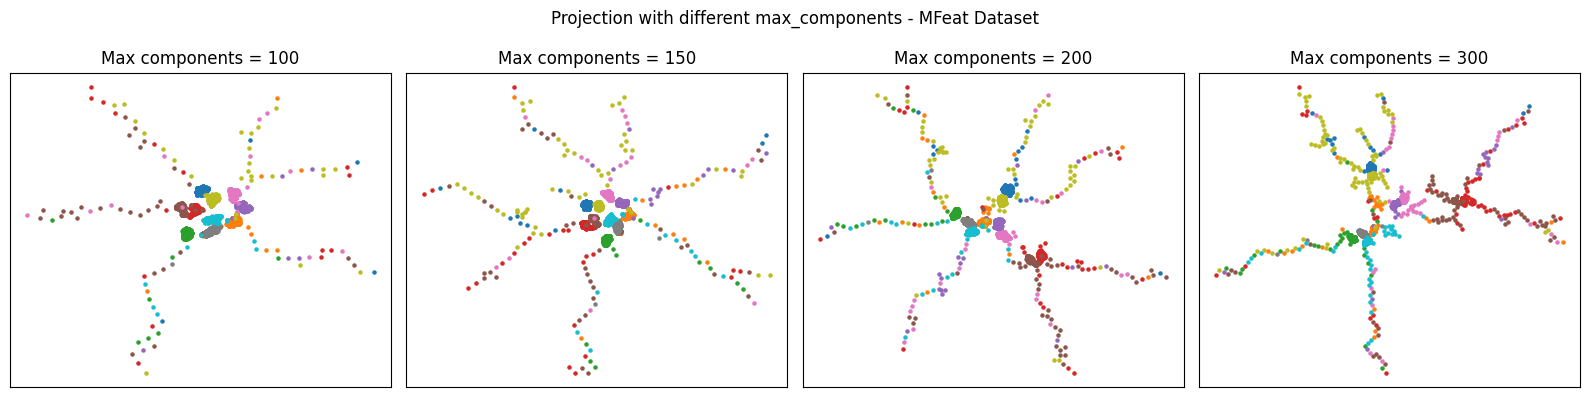

In [70]:
max_components = [100, 150, 200, 300]
fig = plot_proj_max_comps(X_mfeat, y_mfeat, 'class', max_components, rescale=False)
fig.suptitle('Projection with different max_components - MFeat Dataset')
plt.show()